# Download checkpoint

In [ ]:
!rm checkpoint_mae_pretrained.pt

In [ ]:
%%writefile download.sh
FILE_NAME='/kaggle/working/checkpoint_mae_pretrained.pt'
FILE_ID='1VanxPChGPGcOj93h41lDcjee-7GpZXi9'
curl -sc /tmp/cookie "https://drive.google.com/uc?export=download&id=$FILE_ID" > /dev/null
CODE="$(awk '/_warning_/ {print $NF}' /tmp/cookie)"  
curl -Lb /tmp/cookie "https://drive.google.com/uc?export=download&confirm=${CODE}&id=$FILE_ID" -o $FILE_NAME

In [ ]:
!bash download.sh

# Import library

In [1]:
!pip -q install einops wandb

In [2]:
import warnings
warnings.filterwarnings('ignore')

from skimage import io, transform
import os
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision import transforms

import wandb
import random
import math
import numpy as np
from IPython.display import clear_output

from tqdm.notebook import trange, tqdm

import torch.nn.functional as F
import torch.optim as optim
import einops
from einops import rearrange

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Configuration

In [4]:
def seed_anything(seed=2023):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
seed_anything()

In [5]:
IMG_SIZE = 64
BATCH_SIZE = 30

TRAIN_IMG_DIR = '/kaggle/input/aflw-face-crop/images_train/'
TEST_IMG_DIR = '/kaggle/input/aflw-face-crop/images_test/'

TRAIN_ANNOTATION_FILE = '/kaggle/input/aflw-face-crop/train.txt'
TEST_ANNOTATION_FILE = '/kaggle/input/aflw-face-crop/test.txt'

CHECKPOINT_PATH = '/kaggle/working/checkpoint_mae_pretrained.pt'
PROJECT_NAME = 'MAE-AFLW'
API_KEY = 'your key here'

BASE_LR = 1.5e-4
WEIGHT_DECAY = 5e-2
WARMUP_EPOCH = 200
TOTAL_EPOCH = 2000

NUM_POINTS = 19
HEATMAP_SIZE = (64, 64)
SIGMA = 1

RESUME = True

# WanDB

In [ ]:
wandb.login(key=API_KEY)

In [ ]:
run = wandb.init(
    # Set the project where this run will be logged
    project=PROJECT_NAME,
    # Track hyperparameters and run metadata
    config={
        "learning_rate": (BASE_LR * BATCH_SIZE / 256),
        'weight_decay': WEIGHT_DECAY,
        'warmup': WARMUP_EPOCH,
        "epochs": TOTAL_EPOCH,
    })

# DataLoader

In [11]:
meanstd_file = 'mean_std.pth'
if os.path.isfile(meanstd_file):
    meanstd = torch.load(meanstd_file)
else:
    mean = torch.zeros(3)
    std = torch.zeros(3)

    for file_name in os.listdir(TRAIN_IMG_DIR):
        img_path = os.path.join(TRAIN_IMG_DIR, file_name)
        img = read_image(img_path) # CxHxW
        img = img.type('torch.FloatTensor')
        img /= 255
        mean += img.view(img.size(0), -1).mean(1)
        std += img.view(img.size(0), -1).std(1)
    mean /= len(os.listdir(TRAIN_IMG_DIR))
    std /= len(os.listdir(TRAIN_IMG_DIR))
    meanstd = {
        'mean': mean,
        'std': std,
        }
    torch.save(meanstd, 'mean_std.pth')
print(meanstd)

{'mean': tensor([0.5237, 0.4257, 0.3735]), 'std': tensor([0.2417, 0.2220, 0.2119])}


In [76]:
def get_list_img_and_points(annotations_file, img_dir):
    text = None
    img_list = []
    with open(annotations_file, 'r') as f:
        text = f.readlines()
        points = torch.zeros(len(text), NUM_POINTS, 2)
    for i in range(len(text)):
        token = text[i].strip().split()
        img_list.append(os.path.join(img_dir, token[0]))
        points[i] = torch.tensor([float(x) for x in token[1:]], dtype=torch.float32).view(NUM_POINTS, 2)
    return img_list, points
# img_list, points = get_list_img_and_points('/kaggle/input/aflw-face-crop/train.txt', '/kaggle/input/aflw-face-crop/images_train/')

In [77]:
def create_heatmap(img, points, sigma, type='Gaussian'):
    # Draw a 2D gaussian
    # Adopted from https://github.com/anewell/pose-hg-train/blob/master/src/pypose/draw.py
    h,w = img.shape
    tmp_size = sigma * 3
    
    # Check that any part of the gaussian is in-bounds
    x1, y1 = int(points[0] - tmp_size), int(points[1] - tmp_size) # Top-left
    x2, y2 = int(points[0] + tmp_size + 1), int(points[1] + tmp_size + 1) # Bottom right
    if x1 >= w or y1 >= h or x2 < 0 or y2 < 0:
        # If not, just return the image as is
        return img

    # Generate gaussian
    size = 6 * sigma + 1
    x = np.arange(0, size, 1, float)
    y = x[:, np.newaxis]
    x0 = y0 = size // 2
    # The gaussian is not normalized, we want the center value to equal 1
    if type == 'Gaussian':
        g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
    elif type == 'Cauchy':
        g = sigma / (((x - x0) ** 2 + (y - y0) ** 2 + sigma ** 2) ** 1.5)


    # Usable gaussian range
    # Determine the bounds of the source gaussian
    g_x_min, g_x_max = max(0, -x1), min(x2, w) - x1
    g_y_min, g_y_max = max(0, -y1), min(y2, h) - y1

    # Image range
    img_x_min, img_x_max = max(0, x1), min(x2, w)
    img_y_min, img_y_max = max(0, y1), min(y2, h)

    img[img_y_min:img_y_max, img_x_min:img_x_max] = \
      torch.from_numpy(g[g_y_min:g_y_max, g_x_min:g_x_max])

    return img

In [78]:
class AFLW(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_list, self.points = get_list_img_and_points(annotations_file, img_dir)
    def __len__(self):
        return len(os.listdir(self.img_dir))
    def __getitem__(self, idx):
        image = io.imread(self.img_list[idx])
        target = torch.zeros(NUM_POINTS, HEATMAP_SIZE[0], HEATMAP_SIZE[1])
        tpts = self.points[idx].clone()
        for i in range(NUM_POINTS):
            if tpts[i, 1] > 0:
                target[i] = create_heatmap(target[i], tpts[i] * HEATMAP_SIZE[0] - 1, SIGMA)
        if self.transform:
            image = self.transform(image)
        return image, target

In [79]:
from torchvision.transforms import ToTensor, Compose, Normalize
train_dataset = AFLW(TRAIN_ANNOTATION_FILE, TRAIN_IMG_DIR, transform=Compose([ToTensor()])) # Normalize(meanstd['mean'], meanstd['std'])
val_dataset = AFLW(TEST_ANNOTATION_FILE, TEST_IMG_DIR, transform=Compose([ToTensor()]))

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [80]:
train_img, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_img.shape}")
print(f"Labels batch shape: {train_labels.shape}")

Feature batch shape: torch.Size([30, 3, 64, 64])
Labels batch shape: torch.Size([30, 19, 64, 64])


# Visualize Dataset

In [ ]:
train = os.listdir("/kaggle/input/aflw-face-crop/images_train")
test = os.listdir("/kaggle/input/aflw-face-crop/images_test")
print(f"Train files: \t{len(train)}. ---> {train[:3]}")
print(f"Test files:  \t{len(test)}. ---> {test[:3]}")

In [81]:
def visualize_keypoint(begin, end):
    with open(TRAIN_ANNOTATION_FILE, 'r') as f:
        train_text = f.readlines()
        for line in train_text[begin:end+1]:
            line = line.split()
            img = io.imread(os.path.join(TRAIN_IMG_DIR, line[0]))
            for i in range(1, NUM_POINTS * 2, 2):
                x, y = float(line[i]) * IMG_SIZE, float(line[i+1]) * IMG_SIZE
                img = cv2.circle(img, (int(x), int(y)), 0, (0, 255, 0), 1)
            plt.figure()
            plt.imshow(img)

In [83]:
def visualize_heatmap(idx):
    fig, axes = plt.subplots(4, 5, figsize=(12, 12))
    for i, ax in enumerate(axes.flat):
        if(i == 19):
            break
        heatmap = ax.imshow(train_dataset[idx][1][i], cmap='hot', interpolation='nearest')
        ax.set_title(f'Heatmap {i+1}')
    plt.tight_layout()

    # Display the plot
    plt.show()
    
    img = torch.zeros(HEATMAP_SIZE[0], HEATMAP_SIZE[1], 3)
    points = train_dataset[idx][1].sum(axis=0).unsqueeze(0).repeat(3, 1, 1)
    img = train_dataset[idx][0] + points
    plt.imshow(img.permute(1, 2, 0))

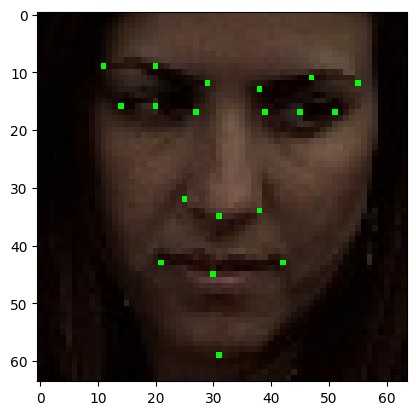

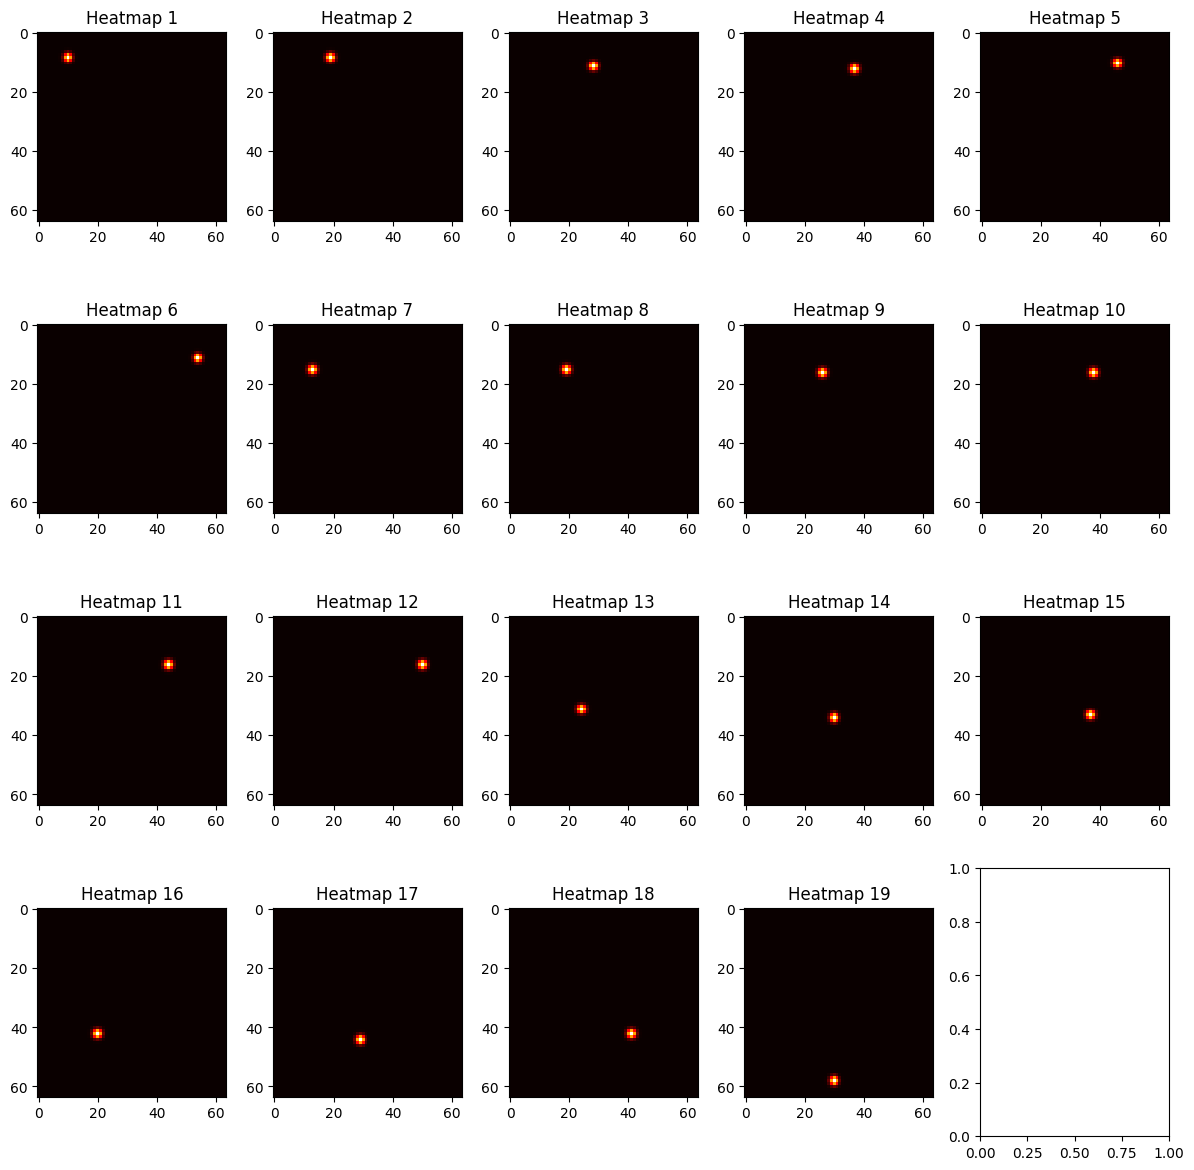

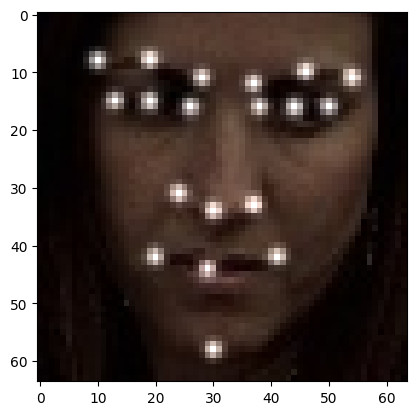

In [85]:
index = 216
begin, end = 216, 216
visualize_keypoint(begin, end)
visualize_heatmap(index)

# Masked AutoEncoder

In [9]:
def patchify(images, patch_size=4):
    """Splitting images into patches.
    Args:
        images: Input tensor with size (batch, channels, height, width)
            We can assume that image is square where height == width.
    Returns:
        A batch of image patches with size (
          batch, (height / patch_size) * (width / patch_size), 
        channels * patch_size * patch_size)
    """
    # BEGIN YOUR CODE
    _, _, height, width = images.shape
    new_height = height / patch_size 
    new_width = width / patch_size
    images = einops.rearrange(images, 'b c (h ps1) (w ps2) -> b (h w) (c ps1 ps2)', h = int(new_height), w = int(new_width)) 
    return images
    # END YOUR CODE

def unpatchify(patches, patch_size=4):
    """Combining patches into images.
    Args:
        patches: Input tensor with size (
        batch, (height / patch_size) * (width / patch_size), 
        channels * patch_size * patch_size)
    Returns:
        A batch of images with size (batch, channels, height, width)
    """
    # BEGIN YOUR CODE
    _, x, y = patches.shape
    height = int(np.sqrt(x))
    width = height
    patches = einops.rearrange(patches, 'b (h w) (c ps1 ps2) -> b c (h ps1) (w ps2)', h = height , w = width, ps1 = patch_size, ps2 = patch_size)
    return patches
    
    # END YOUR CODE

In [10]:
class Transformer(nn.Module):
    """Transformer Encoder 
    Args:
        embedding_dim: dimension of embedding
        n_heads: number of attention heads
        n_layers: number of attention layers
        feedforward_dim: hidden dimension of MLP layer
    Returns:
        Transformer embedding of input
    """
    def __init__(self, embedding_dim=768, n_heads=12, n_layers=12, feedforward_dim=3072):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.feedforward_dim = feedforward_dim
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=embedding_dim,
                nhead=self.n_heads,
                dim_feedforward=self.feedforward_dim,
                activation=F.gelu,
                batch_first=True,
                dropout=0.1,
                norm_first=True
            ),
            num_layers=n_layers,
            norm=nn.LayerNorm(embedding_dim, eps=1e-6)
        )

    def forward(self, x):
        return self.transformer(x)

In [11]:
def index_sequence(x, ids):
    """Index tensor (x) with indices given by ids
    Args:
        x: input sequence tensor, can be 2D (batch x length) or 3D (batch x length x feature)
        ids: 2D indices (batch x length) for re-indexing the sequence tensor
    """
    if len(x.shape) == 3:
        ids = ids.unsqueeze(-1).expand(-1, -1, x.shape[-1])
#         print({'ids_shuffle_expand' : ids})
    return torch.take_along_dim(x, ids, dim=1)

def random_masking(x, keep_length, ids_shuffle):
    """Apply random masking on input tensor
    Args:
        x: input patches (batch x length x feature)
        keep_length: length of unmasked patches
        ids_shuffle: random indices for shuffling the input sequence 
    Returns:
        kept: unmasked part of x
        mask: a 2D (batch x length) mask tensor of 0s and 1s indicated which
            part of x is masked out. The value 0 indicates not masked and 1
            indicates masked.
        ids_restore: indices to restore x. If we take the kept part and masked
            part of x, concatentate them together and index it with ids_restore,
            we should get x back.

    Hint:
        ids_shuffle contains the indices used to shuffle the sequence (patches).
        You should use the provided index_sequence function to re-index the
        sequence, and keep the first keep_length number of patches.
    """
    # BEGIN YOUR CODE
    b, l, f = x.shape
#     print({'x' : x})
#     print({'ids_shuffle' : ids_shuffle})
    ids_restore = torch.argsort(ids_shuffle, dim = 1)
#     print({'ids_restore' : ids_restore})
    kept = index_sequence(x, ids_shuffle)
#     print({'kept': kept})
    kept = kept[:, :keep_length]
#     print({'kept_keep': kept})
    ids_kept = ids_shuffle[:, :keep_length]
#     print({'ids_kept': ids_kept})
    
    mask = torch.ones([b, l], device=x.device)
    mask[:, :keep_length] = 0
    mask = torch.gather(mask, dim=1, index = ids_restore)
#     print({'mask' : mask})
    return kept, mask, ids_restore
    # END YOUR CODE

def restore_masked(kept_x, masked_x, ids_restore):
    """Restore masked patches
    Args:
        kept_x: unmasked patches
        masked_x: masked patches
        ids_restore: indices to restore x
    Returns:
        restored patches
    """
    # BEGIN YOUR CODE
    x = torch.cat((kept_x, masked_x), dim = 1)
    x = torch.gather(x, dim = 1, index = ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))
    
    return x
    
    # END YOUR CODE

In [12]:
class MaskedAutoEncoder(nn.Module):
    """MAE Encoder
    Args:
        encoder: vit encoder
        decoder: vit decoder
        encoder_embedding_dim: embedding size of encoder
        decoder_embedding_dim: embedding size of decoder
        patch_size: image patch size
        num_patches: number of patches
        mask_ratio: percentage of masked patches
    """
    def __init__(self, encoder, decoder, encoder_embedding_dim=768, 
                 decoder_embedding_dim=512, patch_size=4, num_patches=16,
                 mask_ratio=0.75):
        super().__init__()
        self.encoder_embedding_dim = encoder_embedding_dim
        self.decoder_embedding_dim = decoder_embedding_dim
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.mask_ratio = mask_ratio

        self.masked_length = int(num_patches * num_patches * mask_ratio)
        self.keep_length = num_patches * num_patches - self.masked_length

        self.encoder = encoder
        self.decoder = decoder

        self.encoder_input_projection = nn.Linear(patch_size * patch_size * 3, encoder_embedding_dim)
        self.decoder_input_projection = nn.Linear(encoder_embedding_dim, decoder_embedding_dim)
        self.decoder_output_projection = nn.Linear(decoder_embedding_dim, patch_size * patch_size * 3)
        self.cls_token = nn.Parameter(torch.randn(1, 1, encoder_embedding_dim))
        self.encoder_position_encoding = nn.Parameter(torch.randn(1, num_patches * num_patches, encoder_embedding_dim))
        self.decoder_position_encoding = nn.Parameter(torch.randn(1, num_patches * num_patches, decoder_embedding_dim))
        self.masked_tokens = nn.Parameter(torch.randn(1, 1, decoder_embedding_dim))

    def forward_encoder(self, images, ids_shuffle=None):
        """Encode input images
        You should implement the following steps
        (1) patchify images into patches
        (2) linear projection
        (3) add position encoding
        (4) concatenate cls_token and patches embedding and pass it to vit encoder
        """
        batch_size = images.shape[0]
        # Generate random shuffling indices
        if ids_shuffle is None:
            ids_shuffle = torch.argsort(
                torch.rand(
                    (batch_size, self.num_patches * self.num_patches),
                    device=images.device
                ),
                dim=1
            )
        # BEGIN YOUR CODE
        #1
        patches = patchify(images, self.patch_size)

        #2
        projection = self.encoder_input_projection(patches)

        #3
        b, n, l = projection.shape
        projection += self.encoder_position_encoding[:, :(n + 1)]

        #4
        kept, mask, ids_restore = random_masking(projection, n - self.masked_length, ids_shuffle)
        cls_tokens = einops.repeat(self.cls_token, '1 n d -> b n d', b = b)
        x = torch.cat((cls_tokens, kept), dim=1)
        encoder_output = self.encoder(x)
        
        return encoder_output, mask, ids_restore
        # END YOUR CODE

    def forward_decoder(self, encoder_embeddings, ids_restore):
        """Decode encoder embeddings
        You should implement the following steps
        (1) linear projection of encoder embeddings
        (2) restore sequence from masked_patches and encoder predictions
        (3) add position encoding
        (3) readd/use CLS token and decode using ViT decoder 
        (4) projection to predict image patches
        """
        # BEGIN YOUR CODE
        
        #1
        projection = self.decoder_input_projection(encoder_embeddings)
        b, n, l = projection.shape
        #2
        cls_tokens = projection[:, :1, :]
        embedding = projection[:, 1:, :]
        mask_tokens = self.masked_tokens.repeat(b, ids_restore.shape[1] - n + 1, 1)
        
        x = restore_masked(embedding, mask_tokens, ids_restore)
        
        #3
        b, n, l = x.shape
        x += self.decoder_position_encoding[:, :(n + 1)]
        
        #4
        x = torch.cat((cls_tokens, x), dim = 1)
        
        decoder_output = self.decoder(x)
        decoder_output = decoder_output[:, 1:, :]
        #5
        return self.decoder_output_projection(decoder_output)
        # END YOUR CODEc

    def forward(self, images):
        encoder_output, mask, ids_restore = self.forward_encoder(images)
        decoder_output = self.forward_decoder(encoder_output, ids_restore)
        return decoder_output, mask

    def forward_encoder_representation(self, images):
        """Encode images without applying random masking to get representation
        of input images. 

        You should implement splitting images into patches, readd/use CLS token,
        and encoding with ViT encoder.
        """
        # BEGIN YOUR CODE
        patches = patchify(images)

        #2
        projection = self.encoder_input_projection(patches)

        #3
        b, n, l = projection.shape
        projection += self.encoder_position_encoding[:, :(n + 1)]

        #4
        cls_tokens = einops.repeat(self.cls_token, '1 n d -> b n d', b = b)
        x = torch.cat((cls_tokens, projection), dim=1)
        encoder_output = self.encoder(x)
        return encoder_output
        # END YOUR CODE

In [ ]:
a = torch.LongTensor(2, 16, 5).random_(0, 10)
b = torch.argsort(torch.rand((2, 16)), dim = 1)
c = random_masking(a,  4, b)
print({'a': a, 'b' : b, 'c' : c})

# Define MAE Model

In [12]:
# Initilize MAE model
# encoder, decoder, encoder_embedding_dim=256, decoder_embedding_dim=128, patch_size=4, num_patches=16
model = MaskedAutoEncoder(
    Transformer(embedding_dim=768, n_layers=12, n_heads=12, feedforward_dim=768*4),
    Transformer(embedding_dim=512, n_layers=4, n_heads=16, feedforward_dim=512*4), encoder_embedding_dim=768, decoder_embedding_dim=512, patch_size=4, num_patches=16
)
# Move the model to GPU
model.to(device)

MaskedAutoEncoder(
  (encoder): Transformer(
    (transformer): TransformerEncoder(
      (layers): ModuleList(
        (0-11): 12 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (linear1): Linear(in_features=768, out_features=3072, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=3072, out_features=768, bias=True)
          (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    )
  )
  (decoder): Transformer(
    (transformer): TransformerEncoder(
      (layers): ModuleList(
        (0-3): 4 x TransformerEncoderLayer(
 

# Pretrain

In [13]:
optim = torch.optim.AdamW(model.parameters(), lr= BASE_LR * BATCH_SIZE / 256, betas=(0.9, 0.95), weight_decay=WEIGHT_DECAY)
lr_func = lambda epoch: min((epoch + 1) / (WARMUP_EPOCH) + 1e-8, 0.5 * (math.cos(epoch / TOTAL_EPOCH * math.pi) + 1))
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda=lr_func, verbose=True)

Adjusting learning rate of group 0 to 9.3750e-08.


In [ ]:
run = wandb.init(project=PROJECT_NAME, resume=True)

In [15]:
epoch = 0
if RESUME == True:
    checkpoint = torch.load(CHECKPOINT_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optim.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

In [ ]:
while epoch < TOTAL_EPOCH:
    model.train()
    losses = []
    print('Epoch ' + str(epoch))
    data_iterator = tqdm(train_dataloader)
    for x, y in data_iterator:
        x = x.to(device)
        image_patches = patchify(x, patch_size=4)
        predicted_patches, mask = model(x)
        loss = torch.sum(torch.mean(torch.square(image_patches - predicted_patches), dim=-1) * mask) / mask.sum()
        optim.zero_grad()
        loss.backward()
        optim.step()
        losses.append(loss.item())
        data_iterator.set_postfix(loss=np.mean(losses))
    lr_scheduler.step()
    avg_loss = sum(losses) / len(losses)
    print(f'In epoch {epoch}, average traning loss is {avg_loss}.')
    wandb.log({'mae_loss': avg_loss}, step=epoch)
    
    model.eval()
    with torch.no_grad():
        val_img = torch.stack([val_dataset[i][0] for i in range(16)])
        val_img = val_img.to(device)
        predicted_val_img, mask = model(val_img)
        mask = unpatchify(mask.unsqueeze(-1).tile(dims=(1,1,48)), 4)
        predicted_val_img = unpatchify(predicted_val_img, 4)
        predicted_val_img = predicted_val_img * mask + val_img * (1 - mask)
        img = torch.cat([val_img * (1 - mask), predicted_val_img, val_img], dim=0)
        img = rearrange(img, '(v h1 w1) c h w -> c (h1 h) (w1 v w)', w1=2, v=3)
        images = wandb.Image(img)
        wandb.log({"mae_image": images}, step=epoch)
    
    # Periodically save model
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optim.state_dict(),
        'lr_scheduler_state_dict': lr_scheduler.state_dict(),
        'loss': avg_loss
    }, CHECKPOINT_PATH)
    
    epoch += 1
    
    clear_output()

In [ ]:
model.eval()
with torch.no_grad():
    val_img = torch.stack([val_dataset[i][0] for i in range(16)])
    val_img = val_img.to(device)
    predicted_val_img, mask = model(val_img)
    mask = unpatchify(mask.unsqueeze(-1).tile(dims=(1,1,48)), 4)
    predicted_val_img = unpatchify(predicted_val_img, 4)
    predicted_val_img = predicted_val_img * mask + val_img * (1 - mask)
    print(predicted_val_img.shape)
    plt.figure()
    plt.imshow(predicted_val_img[0].squeeze(0).cpu().permute(1, 2, 0))

In [ ]:
from IPython.display import FileLink
FileLink(r'checkpoint_mae_pretrained.pt')

In [15]:
import torch
checkpoint = torch.load('/kaggle/working/checkpoint_mae_pretrained.pt')
epoch = checkpoint['epoch']
loss = checkpoint['loss']
print(epoch, loss)

970 0.003810746108740568


# Finetuning

### Save UNetR_Encoder from MAE Encoder

In [14]:
checkpoint = torch.load(CHECKPOINT_PATH)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [16]:
class UNETR_Encoder(nn.Module):
    def __init__(self, model_pretrained):
        super().__init__()
        self.layers = model_pretrained.encoder.transformer.layers
        self.encoder_input_projection = model_pretrained.encoder_input_projection
        self.encoder_position_encoding = model_pretrained.encoder_position_encoding
        self.cls_token = model_pretrained.cls_token
        self.ext_layers = [3, 6, 9, 12]
    
    def forward(self, images):
        patches = patchify(images)
        projection = self.encoder_input_projection(patches)
        b, n, l = projection.shape
        projection += self.encoder_position_encoding[:, :(n + 1)]
        cls_tokens = einops.repeat(self.cls_token, '1 n d -> b n d', b = b)
        x = torch.cat((cls_tokens, projection), dim=1)

        hidden_states = x
        extract_layers = []
        for i, layer in enumerate(self.layers):
            hidden_states = layer(hidden_states)
            if i + 1 in self.ext_layers:
                extract_layers.append(hidden_states)
        return extract_layers

In [17]:
torch.save(UNETR_Encoder(model), 'UNETR_Encoder.pt')

In [ ]:
from IPython.display import FileLink
FileLink(r'UNETR_Encoder.pt')

### UNetR

In [13]:
class SingleDeconv2DBlock(nn.Module):
    def __init__(self, in_planes, out_planes):
        super().__init__()
        self.block = nn.ConvTranspose2d(in_planes, out_planes, kernel_size=2, stride=2, padding=0, output_padding=0)

    def forward(self, x):
        return self.block(x)
    
class SingleConv2DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size):
        super().__init__()
        self.block = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=1,
                               padding=((kernel_size - 1) // 2))

    def forward(self, x):
        return self.block(x)
    
class Conv2DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3):
        super().__init__()
        self.block = nn.Sequential(
            SingleConv2DBlock(in_planes, out_planes, kernel_size),
            nn.BatchNorm2d(out_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.block(x)

class Deconv2DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3):
        super().__init__()
        self.block = nn.Sequential(
            SingleDeconv2DBlock(in_planes, out_planes),
            SingleConv2DBlock(out_planes, out_planes, kernel_size),
            nn.BatchNorm2d(out_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.block(x)

In [14]:
class UNETR_Encoder(nn.Module):
    def __init__(self, model_pretrained):
        super().__init__()
        self.layers = None
        self.encoder_input_projection = None
        self.encoder_position_encoding = None
        self.cls_token = None
        self.ext_layers = None
    
    def forward(self, images):
        patches = patchify(images)
        projection = self.encoder_input_projection(patches)
        b, n, l = projection.shape
        projection += self.encoder_position_encoding[:, :(n + 1)]
        cls_tokens = einops.repeat(self.cls_token, '1 n d -> b n d', b = b)
        x = torch.cat((cls_tokens, projection), dim=1)

        hidden_states = x
        extract_layers = []
        for i, layer in enumerate(self.layers):
            hidden_states = layer(hidden_states)
            if i + 1 in self.ext_layers:
                extract_layers.append(hidden_states)
        return extract_layers

Tham khao o day (bo z3, z9)
> https://github.com/tamasino52/UNETR/blob/main/unetr.py

In [15]:
class UNETR(nn.Module):
    def __init__(self, encoder, input_dim=3, output_dim=3, embed_dim=768, patch_dim=(16, 16)):
        super().__init__()
        self.patch_dim = patch_dim
        self.encoder = encoder

        self.decoder0 = \
            nn.Sequential(
                Conv2DBlock(input_dim, 32, 3),
                Conv2DBlock(32, 64, 3)
            )

        self.decoder6 = Deconv2DBlock(embed_dim, 128)

        self.decoder12_upsampler = \
            SingleDeconv2DBlock(embed_dim, 128)


        self.decoder6_upsampler = \
            nn.Sequential(
                Conv2DBlock(256, 128),
                Conv2DBlock(128, 128),
                SingleDeconv2DBlock(128, 64)
            )

        self.decoder0_header = \
            nn.Sequential(
                Conv2DBlock(128, 64),
                Conv2DBlock(64, 64),
                SingleConv2DBlock(64, output_dim, 1)
            )

    
    def forward(self, images):
        z = self.encoder(images)
        z0, z3, z6, z9, z12 = images, *z
        z6, z12 = z6[:, 1:, :], z12[:, 1:, :]

        arranger = lambda z_emb: rearrange(z_emb, 'b (x y) d -> b d x y',
                                           x=self.patch_dim[0], y=self.patch_dim[1])
        
        z6, z12 = map(arranger, (z6, z12))
        
        z12 = self.decoder12_upsampler(z12)
        z6 = self.decoder6(z6)
        z6 = self.decoder6_upsampler(torch.cat([z6, z12], dim=1))
        z0 = self.decoder0(z0)
        output = self.decoder0_header(torch.cat([z0, z6], dim=1))
        return output

In [16]:
UNetR_Encoder = torch.load('UNETR_Encoder.pt')
model_finetune = UNETR(UNetR_Encoder, 3, 20)
model_finetune.to(device)
clear_output()